In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

from sklearn.model_selection import train_test_split


2024-03-12 19:01:33.577842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 19:01:33.577974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 19:01:33.748482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install -U tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.15.0


In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Training with validation split: 0.1
/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/glioma_tumor
0
/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/meningioma_tumor
1
/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/no_tumor
2
/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/pituitary_tumor
3
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
Epoch 1/5
39/39 [==============================] - 20s 171ms/step - loss: 2.8495 - accuracy: 0.4035 - top-5-accuracy: 1.0000 - val_loss: 1.1315 - val_accuracy: 0.4212 - val_top-5-accuracy: 1.0000
Epoch 2/5
39/39 [==============================] - 5s 141ms/step - loss: 1.3147 - accuracy: 0.4725 - top-5-accuracy: 1.0000 - val_loss: 1.0189 - val_accuracy: 0.5531 - val_top-5-accuracy: 1.0000
Epoch 3/5
39/39 [==============================] - 6s 157ms/step - loss: 1.1392 - accuracy: 0.5198 - top-5-accuracy: 1.0000 - val_loss: 0.8584 - val_accuracy: 0.

/tmp/ipykernel_26/1735897689.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 4))


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
Epoch 1/5
35/35 [==============================] - 18s 232ms/step - loss: 3.3725 - accuracy: 0.3916 - top-5-accuracy: 1.0000 - val_loss: 1.1301 - val_accuracy: 0.4856 - val_top-5-accuracy: 1.0000
Epoch 2/5
35/35 [==============================] - 4s 108ms/step - loss: 1.4169 - accuracy: 0.4522 - top-5-accuracy: 1.0000 - val_loss: 1.0729 - val_accuracy: 0.4691 - val_top-5-accuracy: 1.0000
Epoch 3/5
35/35 [==============================] - 5s 145ms/step - loss: 1.1696 - accuracy: 0.5106 - top-5-accuracy: 1.0000 - val_loss: 0.8906 - val_accuracy: 0.6708 - val_top-5-accuracy: 1.0000
Epoch 4/5
35/35 [==============================] - 4s 103ms/step - loss: 1.0761 - accuracy: 0.5560 - top-5-accuracy: 1.0000 - val_loss: 0.9002 - val_accuracy: 0.5679 - val_top-5-accuracy: 1.0000
Epoch 5/5
19/19 [==============================] - 0s 21ms/step - loss: 0.9927 - accuracy: 0.6238 - top-5-accuracy: 1.0000
Test accura

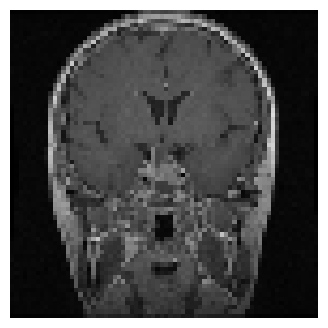

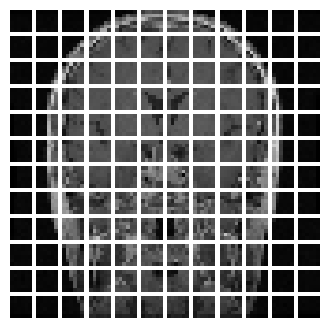

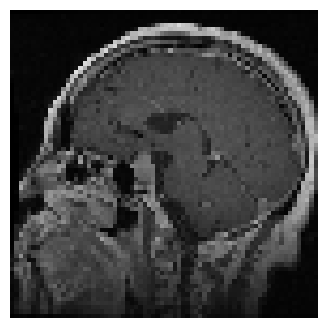

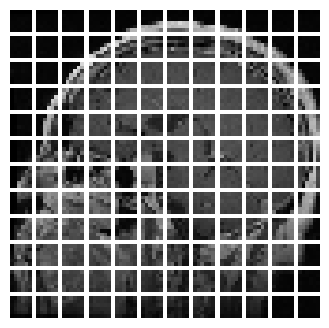

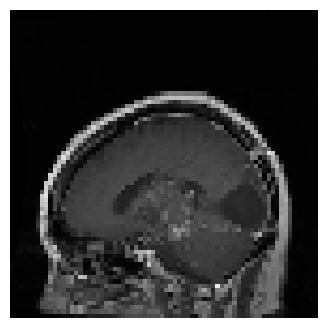

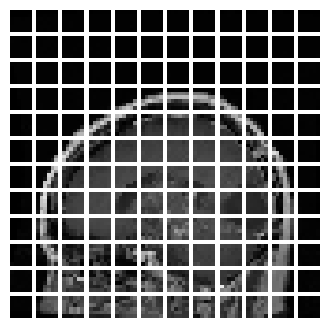

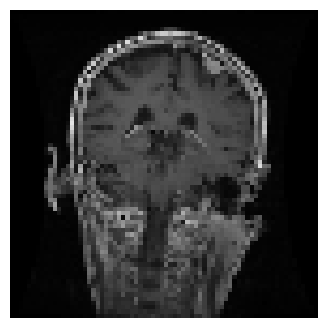

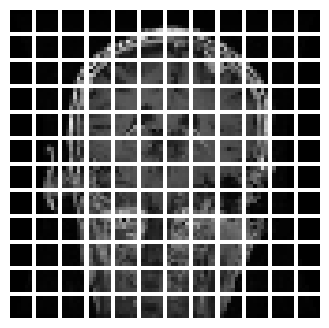

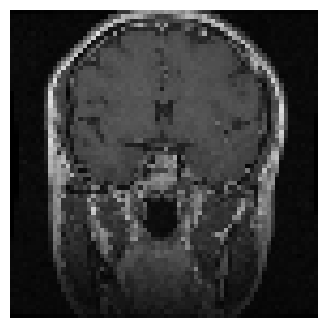

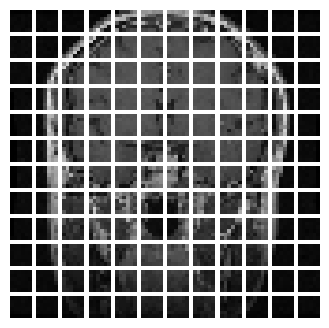

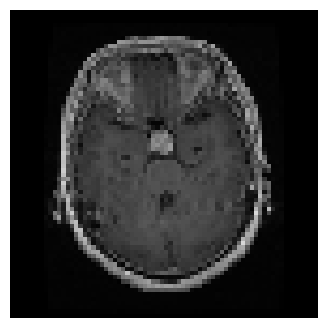

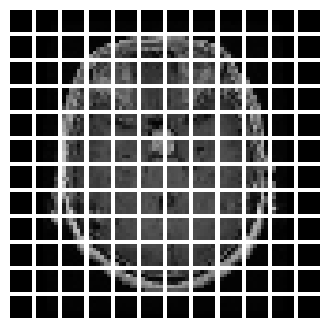

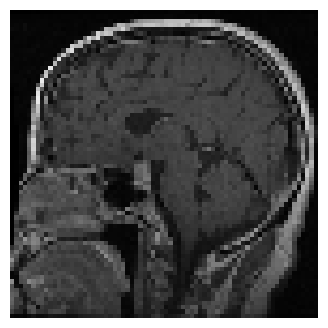

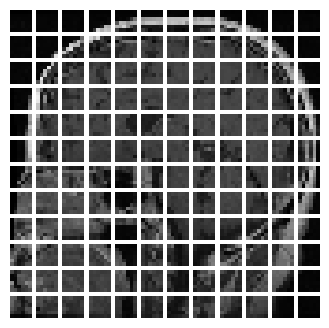

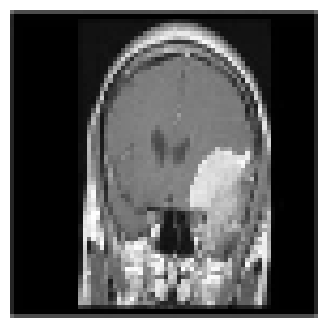

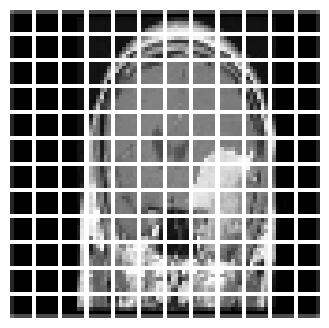

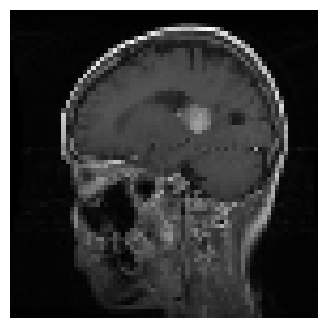

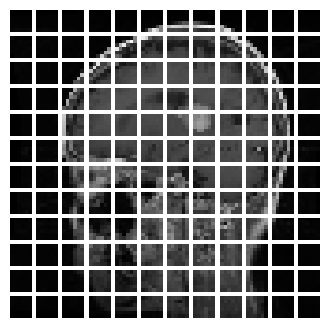

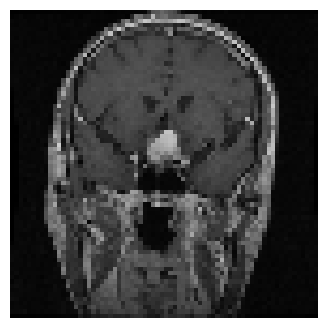

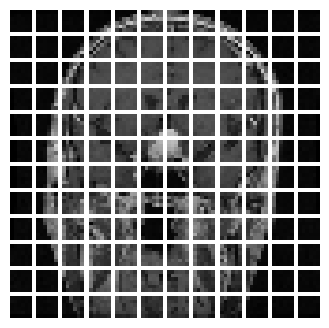

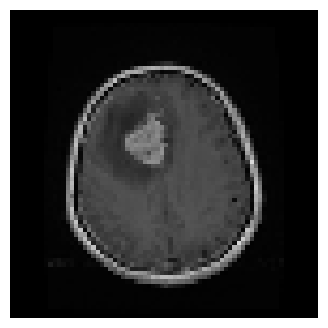

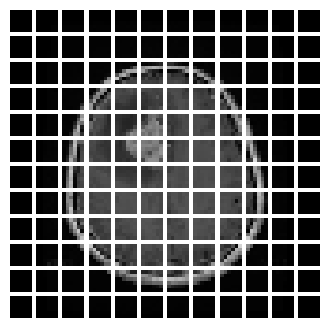

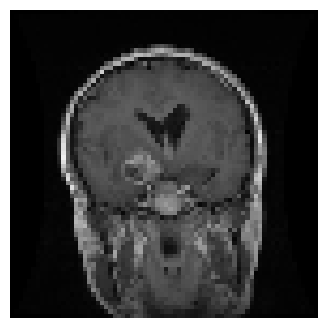

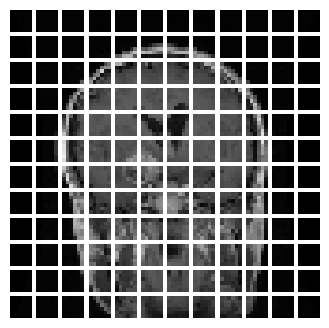

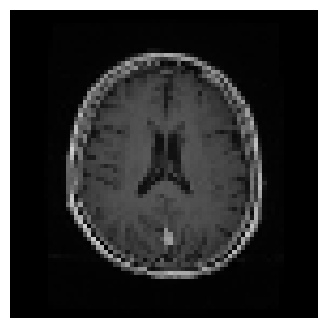

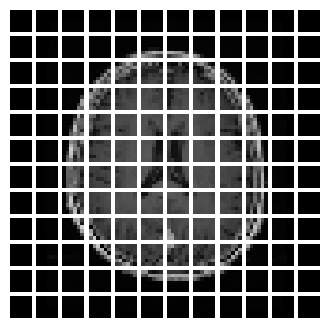

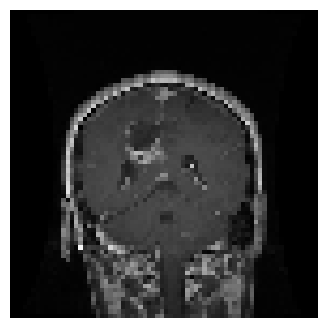

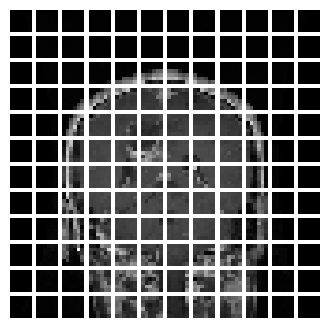

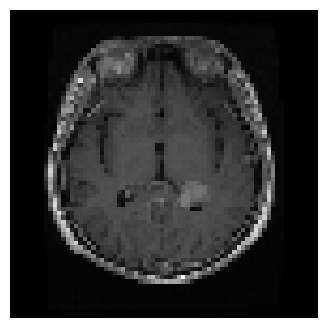

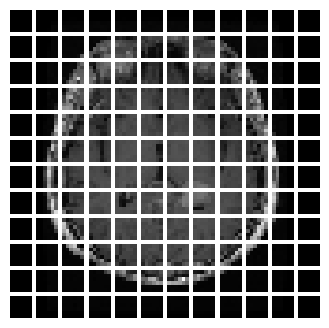

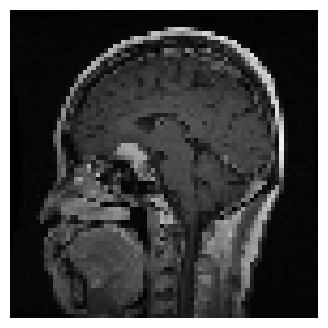

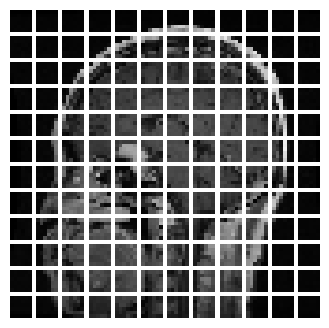

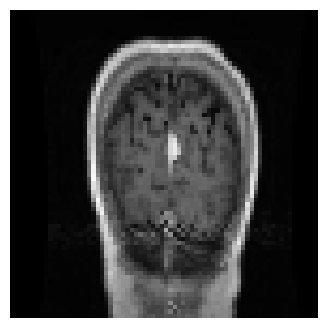

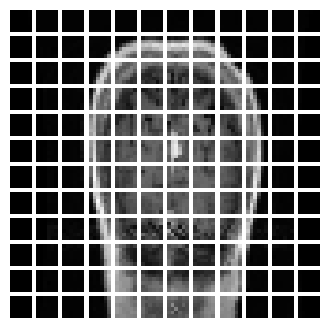

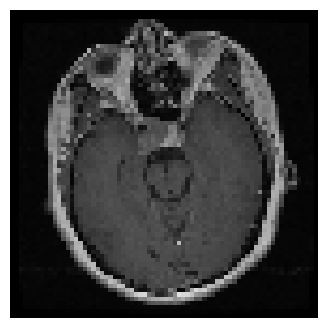

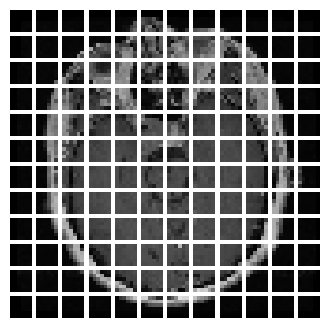

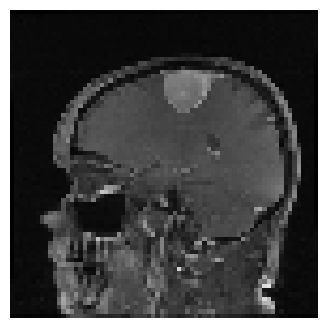

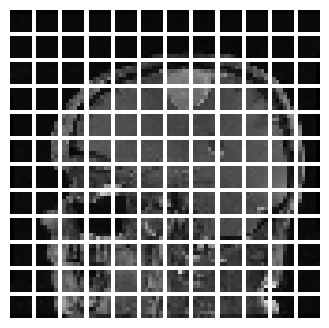

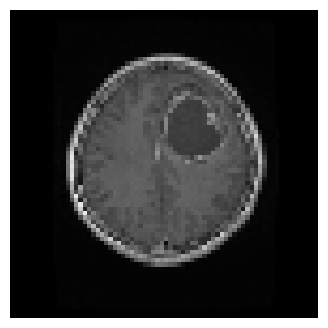

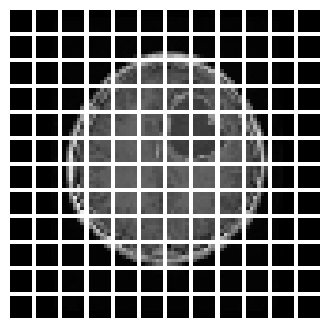

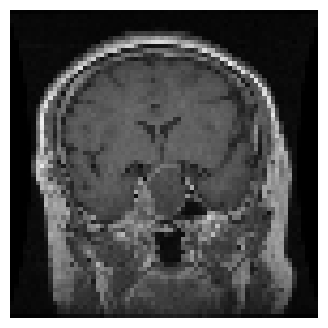

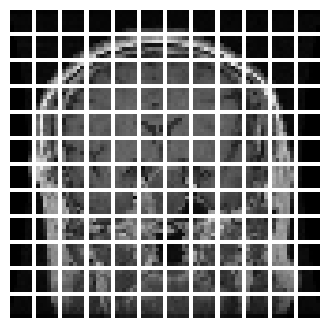

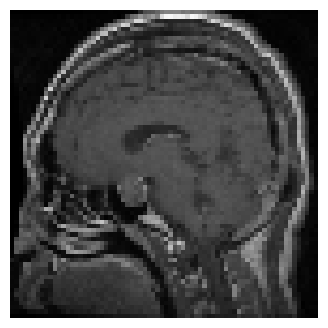

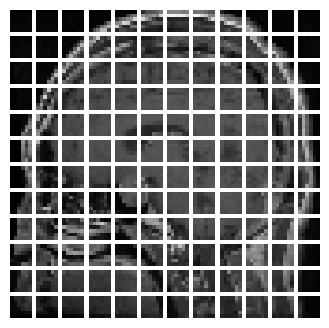

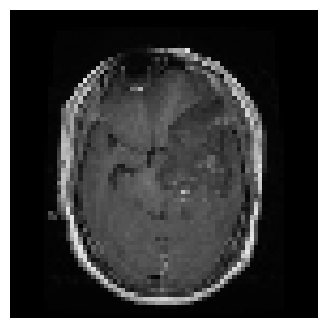

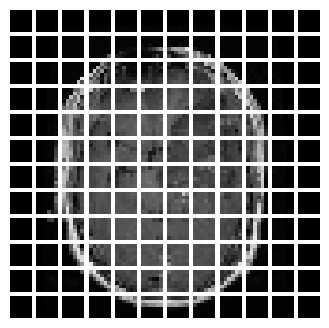

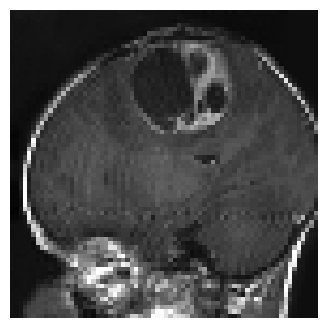

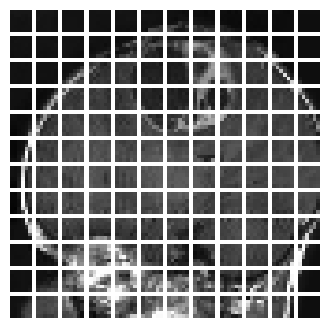

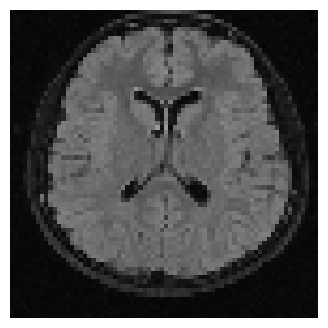

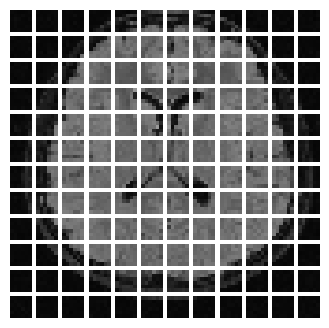

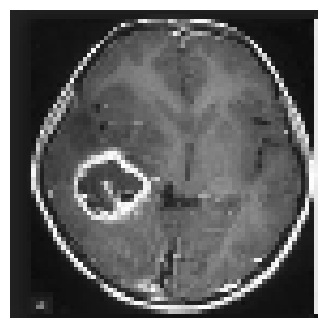

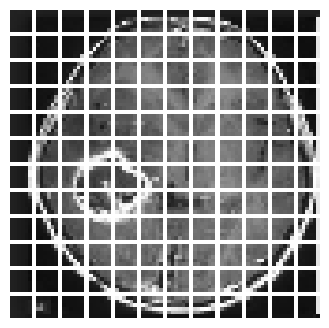

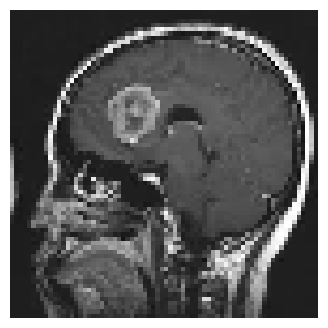

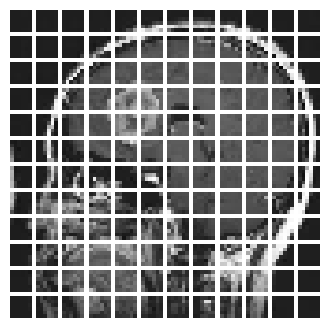

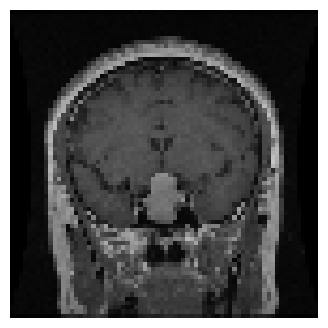

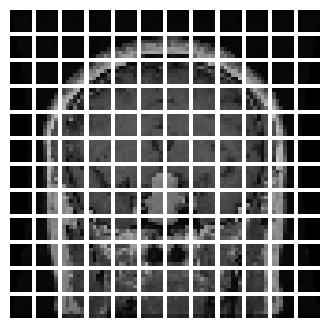

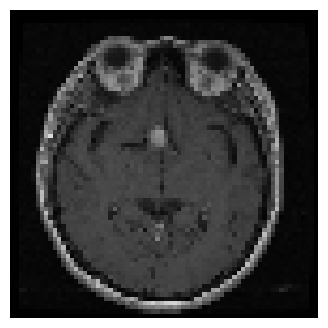

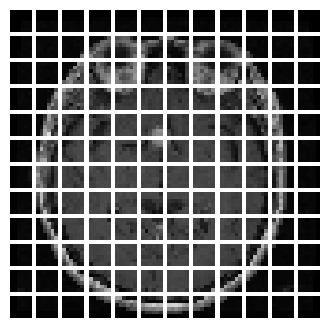

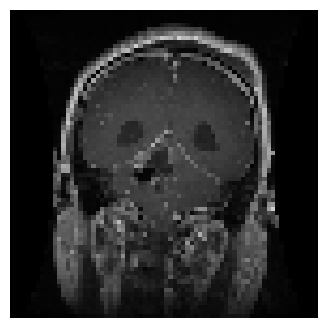

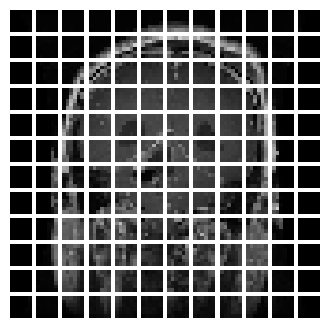

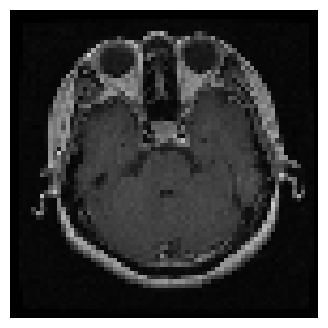

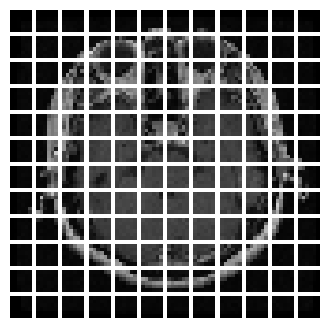

In [5]:
data_dir = "/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/"

tk_categories = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

num_classes = 4

# Define a range for the validation split
validation_splits = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]

accuracies = []

for validation_split in validation_splits:
    print(f"Training with validation split: {validation_split}")
    data = []
    for c in tk_categories:
      folder = os.path.join(data_dir,c)
      label = tk_categories.index(c)
      print(folder)
      print(label)
      for img in os.listdir(folder):
        image = os.path.join(folder,img)
        img_arr = cv2.imread(image)
        img_arr = cv2.resize(img_arr,(72,72))
        data.append([img_arr,label])

    x = []
    y = []
    for feature,label in data:
      x.append(feature)
      y.append(label)

    x = np.array(x)
    y = np.array(y)

    x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=validation_split)
    
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 64
    num_epochs = 5
    image_size = 72  # Final Image Size
    patch_size = 6  # Patch Dimension
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]  # Size of the transformer layers
    transformer_layers = 8
    mlp_head_units = [2048, 1024]  # Size of the dense layers
    
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.Normalization(),
            layers.experimental.preprocessing.Resizing(image_size, image_size),
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(factor=0.02),
            layers.experimental.preprocessing.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_augmentation.layers[0].adapt(x_train)
    
    def multilayer_perceptron(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
        return x
    class Patches(layers.Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding="VALID",
            )
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches
        
    plt.figure(figsize=(4, 4))
    image = x_train[np.random.choice(range(x_train.shape[0]))]
    plt.imshow(image.astype("uint8"))
    plt.axis("off")

    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(image_size, image_size)
    )
    patches = Patches(patch_size)(resized_image)
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")
        
    class PatchEncoder(layers.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PatchEncoder, self).__init__()
            self.num_patches = num_patches
            self.projection = layers.Dense(units=projection_dim)
            self.position_embedding = layers.Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patch):
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patch) + self.position_embedding(positions)
            return encoded
    
    def create_vit_classifier():
        inputs = layers.Input((72,72,3))

        augmented = data_augmentation(inputs)

        patches = Patches(patch_size)(augmented)

        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


        for _ in range(transformer_layers):

            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)

            x2 = layers.Add()([attention_output, encoded_patches])

            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

            x3 = multilayer_perceptron(x3, hidden_units=transformer_units, dropout_rate=0.1)

            encoded_patches = layers.Add()([x3, x2])

        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)

        features = multilayer_perceptron(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

        logits = layers.Dense(4)(features)

        model = keras.Model(inputs=inputs, outputs=logits)
        return model
    
    def run_experiment(model):
        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

        checkpoint_filepath = "/tmp/checkpoint"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )
        
        earlystopping = EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_split=0.1,
            callbacks=[checkpoint_callback, earlystopping]
        )

        model.load_weights(checkpoint_filepath)
        _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

        return history
    
    vit_classifier = create_vit_classifier()
    history = run_experiment(vit_classifier)
    
    accuracy = history.history['val_accuracy'][-1]
    accuracies.append(accuracy)
    print(f"Overall accuracy: {accuracy}")

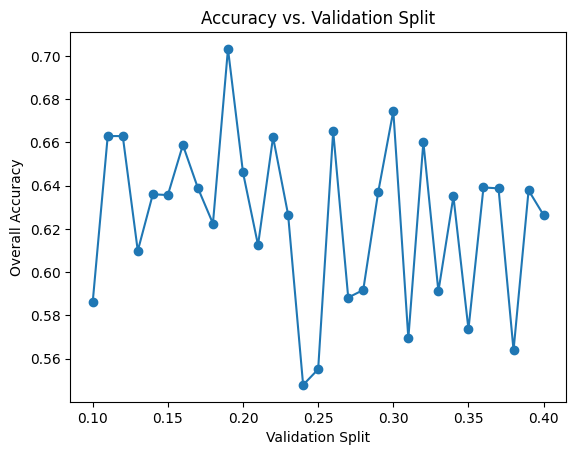

In [6]:
# Plot the accuracy vs. test size graph
plt.plot(validation_splits, accuracies, marker='o')
plt.xlabel('Validation Split')
plt.ylabel('Overall Accuracy')
plt.title('Accuracy vs. Validation Split')
plt.show()

In [7]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='train_accuracy')
# plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.1, 1.2])
# plt.legend(loc='lower right')

In [8]:
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label = 'validation_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0, 0.8])
# plt.legend(loc='upper right')

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_pred = vit_classifier.predict(x_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# def plot_confusion_matrix(confusion_mtx, labels):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(
#         confusion_mtx,
#         annot=True,
#         fmt="d",
#         cmap="Purples",
#         xticklabels=labels,
#         yticklabels=labels,
#     )
#     plt.xlabel("Predicted Labels")
#     plt.ylabel("True Labels")
#     plt.title("Confusion Matrix")
#     plt.show()

# # Define your class labels (replace this with your actual class labels)
# class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# # Plot the confusion matrix heatmap
# plot_confusion_matrix(confusion_mtx, class_labels)

In [10]:
# from sklearn.metrics import classification_report

# # After evaluating your model and calculating y_pred_classes
# classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)

# # Print the classification report
# print(classification_rep)